In [1]:
%matplotlib inline
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import struct
import pickle
import pandas as pd
import random

In [3]:
import sys
sys.path.append('../../src')

In [4]:
from pylab import rcParams
from IPython.display import clear_output
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_columns = 999

In [5]:
from utils import FloatConvert32, FloatConvert64
from microssembly import Microssembly
from price_generator import random_walk, random_price

In [6]:
def get_strategy_signal(price, short_ma, long_ma, demo=False):
    short_ma = abs(int(short_ma))
    long_ma = abs(int(long_ma))
    shares = 1

    try:
        ms = price.rolling(short_ma).mean()
        ml = price.rolling(long_ma).mean()

        buy = (ms > ml) & (ms.shift() < ml.shift())  # ma cross up
        sell = (ms < ml) & (ms.shift() > ml.shift())  # ma cross down
        signal = pd.Series(index=price.index)
        signal[buy[buy != False].index] = shares
        signal[sell[sell != False].index] = 0
    except Exception as e:
        print('Long {} Short {}'.format(long_ma, short_ma))
        raise e

    if demo is True:
        ax = price.plot()
        ms.plot()
        ml.plot()
        plt.legend(['price', 'Short MA', 'Long MA'], loc='best')
        ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)

    return signal

def get_strategy_signal_1(price):
    return get_strategy_signal(price, 2, 8, False)

((128,), (21,), 2011-09-07    1.0
 2011-09-24    0.0
 2011-09-27    1.0
 2011-10-06    0.0
 2011-10-09    1.0
 dtype: float64)

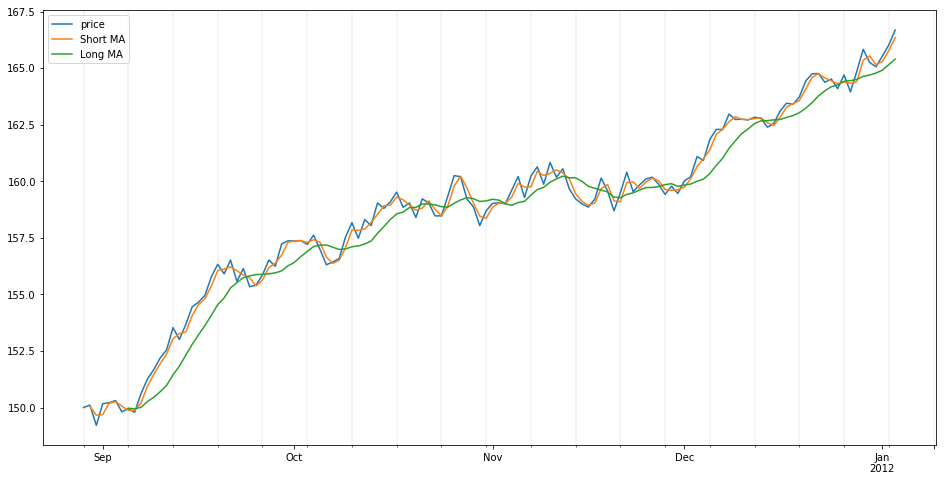

In [7]:
price = random_price()
signal = get_strategy_signal(price, 2, 8, True)
price.shape, signal.dropna().shape, signal.dropna()[:5]

In [8]:
from simple_strategy import get_signal, loss_function, eval_individual, find_best_model

In [9]:
loss = []
for _ in range(1000):
    price = random_price()
    random_code = ''.join(list(map(str, np.random.randint(0, 2, size=1000))))
    signal = get_signal(price, random_code)
    observed_signal = get_strategy_signal_1(price)
    l = loss_function(signal, observed_signal)    
    if(l > 0):
        loss.append(l)
print(np.average(loss))

0.4875987340247171


In [10]:
pop, hof, _ = find_best_model(get_strategy_signal_1,
                              ngen=100,
                              pop_size=1000,
                              mutpb=0.001,
                              indpb=0.1)

gen	nevals	avg     	std     	min	max  
0  	1000  	0.185188	0.241853	0  	0.875
1  	999   	0.498766	0.0539923	0.117647	0.9375
2  	1011  	0.504875	0.0518777	0.190476	0.9375
3  	994   	0.506808	0.0599353	0.214286	1     
4  	965   	0.506884	0.0556512	0.190476	1     
5  	1006  	0.516472	0.0800308	0.190476	1     
6  	933   	0.51635 	0.0813064	0.190476	1     
7  	995   	0.52386 	0.0918332	0.318182	1     
8  	1026  	0.537842	0.121401 	0.294118	1     
9  	990   	0.560574	0.151622 	0.15    	1     
10 	1019  	0.581334	0.171463 	0.15    	1     
11 	988   	0.603343	0.188488 	0.125   	1     
12 	1009  	0.647996	0.208458 	0.04    	1     
13 	993   	0.678327	0.212747 	0.368421	1     
14 	1036  	0.709952	0.216824 	0.285714	1     
15 	989   	0.751741	0.216181 	0.214286	1     
16 	1004  	0.789016	0.201541 	0.357143	1     
17 	1020  	0.813569	0.191698 	0.0555556	1     
18 	990   	0.842225	0.17107  	0.428571 	1     
19 	1009  	0.846674	0.168455 	0.380952 	1     
20 	1019  	0.87948 	0.141691 	0.117647 	1    

In [11]:
best_code = ''.join(map(str, hof[0]))

In [12]:
all_loss = []
for i in range(100):
    price = random_price()
    signal = get_signal(price, best_code)
    observed_signal = get_strategy_signal_1(price)
    all_loss.append(loss_function(signal, observed_signal))
np.average(all_loss)

0.9785420410212273

In [13]:
signal.dropna()[:10]

2015-09-06    0.0
2015-09-07    1.0
2015-09-08    1.0
2015-09-09    0.0
2015-09-10    1.0
2015-09-11    0.0
2015-09-12    0.0
2015-09-13    0.0
2015-09-14    0.0
2015-09-15    0.0
dtype: float64

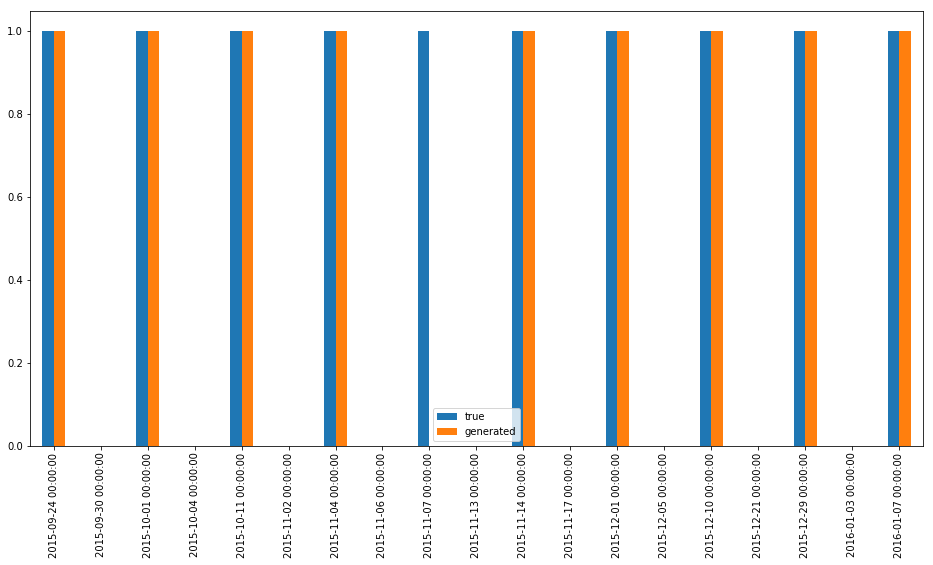

In [14]:
pd.DataFrame({'true': observed_signal, 'generated': signal}).dropna().plot.bar()

In [15]:
import microssembly
mssembly = Microssembly(in_memory_length=3, out_memory_length=1, registers_length=3)
mssembly.out_memory[0] = np.NaN
mssembly.run(best_code)

['bin-max [2] [4]',
 'mov [5] [5]',
 'add [6] [3]',
 'bin-max [5] [6]',
 'div [0] [2]',
 'min [7] [3]',
 'inc [5]',
 'inc [4]',
 'inc [3]',
 'bin-max [0] [0]',
 'min [5] [6]',
 'load [7] [5]',
 'div [3] [2]',
 'div [3] [6]',
 'bin-min [1] [3]',
 'mov [4] [7]',
 'bin-min [5] [7]',
 'inc [1]',
 'unload [5] [1]',
 'add [4] [5]',
 'unload [3] [1]',
 'bin-min [4] [7]',
 'max [6] [0]',
 'div [4] [0]',
 'stop-ignore',
 'bin-min [3] [2]',
 'load [1] [7]',
 'unload [0] [0]',
 'load [0] [3]',
 'mov [3] [3]',
 'load [5] [0]',
 'bin-max [0] [7]',
 'min [6] [6]',
 'dec [0]',
 'div [4] [4]',
 'dec [3]',
 'unload [4] [0]',
 'load [7] [6]',
 'load [1] [4]',
 'inc [5]',
 'inc [1]',
 'load [2] [2]',
 'div [4] [7]',
 'mov [4] [2]',
 'unload [6] [1]',
 'bin-min [7] [3]',
 'min [6] [2]',
 'min [2] [0]',
 'dec [6]',
 'bin-min [0] [7]',
 'load [5] [3]',
 'load [1] [1]',
 'div [2] [0]',
 'ignore',
 'stop-ignore',
 'bin-max [1] [4]',
 'stop-ignore',
 'div [4] [7]',
 'bin-min [7] [4]',
 'div [1] [0]',
 'unload 

In [95]:
a = sum(signal[observed_signal[observed_signal == 1].index] == 1) / len(observed_signal[observed_signal == 1]) + 1e-9
b = sum(signal[observed_signal[observed_signal == 0].index] == 0) / len(observed_signal[observed_signal == 0]) + 1e-9
c = 1 - np.abs(len(observed_signal.dropna()) - len(signal.dropna())) / max(len(observed_signal.dropna()), len(signal.dropna())) + 1e-9

In [96]:
3 / (1/a + 1/b + 1/c)

0.33906146910836854

In [105]:
a = 0.9
b = 0.9
c = 0.3
3 / (1/a + 1/b + 1/c)

0.54

In [107]:
d = pd.read_csv('/Users/vorl/Downloads/allstocks.csv')

In [109]:
d[(d.buy == 1) & (d.sell == 1)]

,Unnamed: 0,Date,Open,High,Low,Close,Adj.Close,Volume,pos,buy,sell,Company


In [110]:
d.shape

(101673, 12)